In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs

import torch
import torch.nn as nn
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import ast

print(torch.__version__)

2.5.0+cu121


In [3]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 500,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 50,   # Evaluation frequency
    "BATCH_SIZE": 32,       # Batch size
    "LR": 5e-4,             # Learning rate
    "LR_DECAY_GAMMA": 0.5,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 100, # Learning rate decay steps

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH":'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/gabri_dataset-cell-cycle_2:3.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    
    "TYPE_HEAD":"MLP",# "attention", #"MLP",
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls
    "FROM_PRECOMPUTED_EMBS": True,
}
config["PRECOMPUTED_EMBS_PATH"] = (
    f"{config['DATASET_PATH'].split('.')[0]}_embs_"
    f"{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.pt"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [4]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [5]:
data = pd.read_csv(config["DATASET_PATH"])

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
}


# Add or Create embs

Only if "from_precomputed_embs" is True

In [6]:
# add or use preocmputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if not os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        print("Embeddings file not found. Calculating embs...")
        
        protein_names = []
        embeddings_list = []

        esm_model.eval()

        for protein, input_ids, attention_mask in tqdm(
            zip(cache_data["protein"], cache_data["input_ids"], cache_data["attention_mask"]),
            total=len(cache_data["protein"]),
            desc="Processing proteins"
        ):            
            with torch.no_grad():
                input_ids = input_ids.unsqueeze(0).to(config["DEVICE"]) # as we take one at a time we need to squeeze
                attention_mask = attention_mask.unsqueeze(0).to(config["DEVICE"])

            outputs_esm = esm_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

            if config["TYPE_EMB_FOR_CLASSIFICATION"] == "agg_mean":
                input_class_head = torch.mean(outputs_esm.last_hidden_state, dim=1)
            # ... (Rest of the aggregation logic: agg_max, cls, concat) ...
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "agg_max":
                input_class_head, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "cls":
                input_class_head = outputs_esm.last_hidden_state[:, 0, :] 
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "concat(agg_mean, agg_max)":
                mean_pool = torch.mean(outputs_esm.last_hidden_state, dim=1)
                max_pool, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
                input_class_head = torch.cat((mean_pool, max_pool), dim=1) 
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "concat(agg_mean, agg_max, cls)":
                mean_pool = torch.mean(outputs_esm.last_hidden_state, dim=1)
                max_pool, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
                cls = outputs_esm.last_hidden_state[:, 0, :] 
                input_class_head = torch.cat((mean_pool, max_pool, cls), dim=1) 
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "contextualized_embs":
                input_class_head = outputs_esm.last_hidden_state

            protein_names.append(protein)
            embeddings_list.append(input_class_head.squeeze(0).detach().cpu())

        print("Saving embeddings to fast PyTorch cache...")
        # Create a dictionary structure to save both the names and the list of tensors
        emb_dict = {
            'protein': protein_names,
            'embedding': torch.stack(embeddings_list)
        }
        torch.save(emb_dict, config["PRECOMPUTED_EMBS_PATH"])

    print(f"Reading back from file: {config['PRECOMPUTED_EMBS_PATH']}...")
    # ATTENTION: order shodul be the same
    emb_dict = torch.load(config["PRECOMPUTED_EMBS_PATH"], weights_only=False)
    cache_data["embedding"] = emb_dict["embedding"]

Reading back from file: /home/gdallagl/myworkdir/ESMSec/data/cell_cycle/gabri_dataset-cell-cycle_2:3_embs_facebook-esm2_t33_650M_UR50D_cls.pt...


In [7]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim

print(config["PRECOMPUTED_EMBS_DIM"])

1280


Original: 426, Truncated: 426, Tokenized (no pad): 428
Original: 446, Truncated: 446, Tokenized (no pad): 448
Original: 904, Truncated: 904, Tokenized (no pad): 906


,Unnamed: 0,UniRef50_Cluster,protein,gene,label,sequence,set,truncated_sequence,input_ids,attention_mask
0,0,UniRef50_P08476,P08476,INHBA,1,MPLLWLRGFLLASCWIIVRSSPTPGSEGHSAAPDCPSCALAALPKD...,train,MPLLWLRGFLLASCWIIVRSSPTPGSEGHSAAPDCPSCALAALPKD...,"[tensor(0), tensor(20), tensor(14), tensor(4),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1,MREIVHIQAGQCGNQIGTKFWEVISDEHGIDPAGGYVGDSALQLER...,train,MREIVHIQAGQCGNQIGTKFWEVISDEHGIDPAGGYVGDSALQLER...,"[tensor(0), tensor(20), tensor(10), tensor(9),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


protein                  : list length 872
label                    : Tensor shape (872,)
set                      : list length 872
sequence                 : list length 872
truncated_sequence       : list length 872
input_ids                : Tensor shape (872, 1000)
attention_mask           : Tensor shape (872, 1000)
embedding                : Tensor shape (872, 1280)


<Axes: >

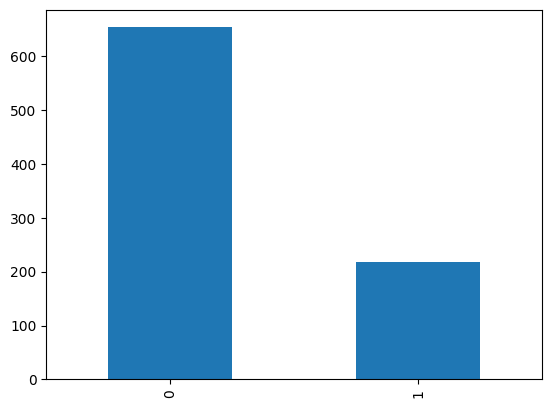

In [8]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

display(data.head(2))

for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [9]:
# ATTENTION: the name of the cols in the df must be speicifc
train_dl = my_dataset.create_dataloader(cache_data, "train", config["BATCH_SIZE"], shuffle=True)
valid_dl = my_dataset.create_dataloader(cache_data, "val", config["BATCH_SIZE"], shuffle=False)
test_dl  = my_dataset.create_dataloader(cache_data, "test", config["BATCH_SIZE"], shuffle=False)


# little check:
batch = next(iter(train_dl))  # get one batch
input_ids, attention_mask, labels, names, embs = batch
print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")

=== Batch Information ===
Batch size: 32

Input IDs: Tensor, shape = (32, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (32, 1000), dtype = torch.int64
Labels: Tensor, shape = (32,), dtype = torch.int64
First 5 labels: tensor([0, 0, 0, 0, 0])
Names: List, length = 32, first 5 = ['A6NE52', 'Q86SJ6', 'P15954', 'H0UI37', 'Q9UBF1']
Embeddings: Tensor, shape = (32, 1280), dtype = torch.float32


# Instantiate Full model

In [10]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

MLPHead(
  (layer1): Sequential(
    (0): Linear(in_features=1280, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1280, out_features=628, bias=True)
    (1): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

ESM hidden dim 1280 



# Define weighted loss fucntion

In [11]:
# Get class counts (ordered by label)
class_counts = data[data.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()

# Total number of samples
N = sum(class_counts_list)

# Compute class weights using w_i =  N / N_i
class_weights = torch.tensor([N / class_counts_list[0], N / class_counts_list[1]], dtype=torch.float)

# scale to avoid biased towrad class 1
#reduces bias toward class 1 while still giving minority class more importance.
class_weights = class_weights / class_weights.max()  # max weight = 1

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {class_counts_list[0]}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {class_counts_list[1]}, weight: {class_weights[1]:.4f}")

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 523, 1: 174}
Class 0 count: 523, weight: 0.3327
Class 1 count: 174, weight: 1.0000


# Train

In [12]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 2:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 3:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 4:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 5:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 6:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 7:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 8:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 9:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 10:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 11:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 12:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 13:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 14:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 15:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 16:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 17:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 18:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 19:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 20:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 21:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 22:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 23:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 24:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 25:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 26:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 27:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 28:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 29:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 30:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 31:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 32:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 33:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 34:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 35:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 36:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 37:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 38:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 39:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 40:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 41:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 42:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 43:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 44:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 45:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 46:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 47:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 48:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 49:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 50:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 50 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3153, Acc: 91.54%, Balanced Acc: 86.88%, F1: 0.8207, MCC: 0.7677


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.6025, Acc: 77.01%, Balanced Acc: 62.06%, F1: 0.4118, MCC: 0.3041


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4229, Acc: 85.23%, Balanced Acc: 76.52%, F1: 0.6667, MCC: 0.5816


Epoch 51:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 52:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 53:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 54:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 55:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 56:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 57:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 58:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 59:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 60:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 61:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 62:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 63:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 64:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 65:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 66:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 67:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 68:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 69:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 70:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 71:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 72:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 73:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 74:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 75:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 76:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 77:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 78:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 79:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 80:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 81:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 82:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 83:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 84:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 85:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 86:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 87:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 88:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 89:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 90:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 91:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 92:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 93:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 94:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 95:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 96:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 97:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 98:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 99:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 100:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 100 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2518, Acc: 85.80%, Balanced Acc: 90.15%, F1: 0.7765, MCC: 0.7139


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.8727, Acc: 66.67%, Balanced Acc: 67.17%, F1: 0.5085, MCC: 0.3019


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.7353, Acc: 72.73%, Balanced Acc: 72.73%, F1: 0.5714, MCC: 0.4042


Epoch 101:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 102:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 103:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 104:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 105:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 106:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 107:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 108:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 109:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 110:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 111:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 112:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 113:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 114:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 115:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 116:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 117:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 118:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 119:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 120:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 121:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 122:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 123:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 124:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 125:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 126:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 127:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 128:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 129:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 130:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 131:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 132:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 133:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 134:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 135:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 136:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 137:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 138:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 139:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 140:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 141:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 142:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 143:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 144:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 145:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 146:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 147:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 148:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 149:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 150:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 150 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0927, Acc: 97.99%, Balanced Acc: 97.89%, F1: 0.9605, MCC: 0.9472


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.1318, Acc: 71.26%, Balanced Acc: 55.21%, F1: 0.2857, MCC: 0.1270


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.5810, Acc: 86.36%, Balanced Acc: 75.76%, F1: 0.6667, MCC: 0.6099


Epoch 151:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 152:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 153:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 154:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 155:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 156:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 157:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 158:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 159:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 160:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 161:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 162:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 163:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 164:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 165:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 166:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 167:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 168:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 169:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 170:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 171:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 172:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 173:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 174:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 175:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 176:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 177:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 178:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 179:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 180:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 181:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 182:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 183:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 184:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 185:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 186:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 187:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 188:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 189:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 190:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 191:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 192:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 193:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 194:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 195:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 196:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 197:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 198:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 199:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 200:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 200 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0696, Acc: 98.13%, Balanced Acc: 97.99%, F1: 0.9632, MCC: 0.9509


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.1430, Acc: 71.26%, Balanced Acc: 58.22%, F1: 0.3590, MCC: 0.1801


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.6145, Acc: 86.36%, Balanced Acc: 77.27%, F1: 0.6842, MCC: 0.6124


Epoch 201:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 202:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 203:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 204:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 205:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 206:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 207:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 208:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 209:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 210:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 211:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 212:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 213:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 214:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 215:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 216:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 217:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 218:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 219:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 220:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 221:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 222:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 223:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 224:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 225:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 226:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 227:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 228:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 229:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 230:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 231:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 232:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 233:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 234:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 235:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 236:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 237:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 238:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 239:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 240:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 241:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 242:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 243:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 244:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 245:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 246:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 247:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 248:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 249:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 250:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 250 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0926, Acc: 95.12%, Balanced Acc: 96.75%, F1: 0.9110, MCC: 0.8844


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.3021, Acc: 66.67%, Balanced Acc: 65.66%, F1: 0.4912, MCC: 0.2777


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.9880, Acc: 79.55%, Balanced Acc: 78.79%, F1: 0.6538, MCC: 0.5260


Epoch 251:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 252:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 253:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 254:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 255:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 256:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 257:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 258:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 259:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 260:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 261:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 262:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 263:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 264:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 265:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 266:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 267:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 268:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 269:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 270:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 271:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 272:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 273:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 274:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 275:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 276:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 277:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 278:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 279:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 280:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 281:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 282:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 283:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 284:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 285:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 286:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 287:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 288:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 289:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 290:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 291:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 292:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 293:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 294:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 295:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 296:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 297:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 298:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 299:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 300:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 300 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0241, Acc: 99.14%, Balanced Acc: 99.43%, F1: 0.9831, MCC: 0.9775


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.4675, Acc: 71.26%, Balanced Acc: 61.22%, F1: 0.4186, MCC: 0.2280


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.8790, Acc: 82.95%, Balanced Acc: 76.52%, F1: 0.6512, MCC: 0.5387


Epoch 301:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 302:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 303:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 304:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 305:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 306:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 307:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 308:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 309:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 310:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 311:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 312:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 313:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 314:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 315:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 316:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 317:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 318:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 319:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 320:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 321:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 322:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 323:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 324:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 325:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 326:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 327:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 328:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 329:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 330:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 331:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 332:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 333:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 334:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 335:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 336:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 337:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 338:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 339:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 340:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 341:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 342:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 343:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 344:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 345:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 346:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 347:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 348:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 349:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 350:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 350 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0148, Acc: 99.14%, Balanced Acc: 99.43%, F1: 0.9831, MCC: 0.9775


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.6495, Acc: 67.82%, Balanced Acc: 58.92%, F1: 0.3913, MCC: 0.1734


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.9004, Acc: 81.82%, Balanced Acc: 75.76%, F1: 0.6364, MCC: 0.5152


Epoch 351:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 352:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 353:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 354:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 355:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 356:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 357:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 358:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 359:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 360:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 361:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 362:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 363:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 364:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 365:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 366:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 367:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 368:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 369:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 370:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 371:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 372:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 373:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 374:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 375:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 376:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 377:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 378:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 379:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 380:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 381:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 382:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 383:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 384:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 385:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 386:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 387:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 388:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 389:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 390:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 391:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 392:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 393:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 394:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 395:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 396:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 397:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 398:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 399:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 400:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 400 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0071, Acc: 99.71%, Balanced Acc: 99.81%, F1: 0.9943, MCC: 0.9924


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.7195, Acc: 68.97%, Balanced Acc: 59.69%, F1: 0.4000, MCC: 0.1909


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.9846, Acc: 81.82%, Balanced Acc: 75.76%, F1: 0.6364, MCC: 0.5152


Epoch 401:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 402:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 403:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 404:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 405:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 406:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 407:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 408:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 409:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 410:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 411:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 412:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 413:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 414:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 415:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 416:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 417:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 418:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 419:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 420:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 421:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 422:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 423:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 424:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 425:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 426:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 427:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 428:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 429:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 430:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 431:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 432:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 433:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 434:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 435:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 436:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 437:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 438:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 439:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 440:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 441:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 442:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 443:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 444:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 445:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 446:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 447:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 448:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 449:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 450:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 450 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0045, Acc: 99.86%, Balanced Acc: 99.90%, F1: 0.9971, MCC: 0.9962


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.7498, Acc: 72.41%, Balanced Acc: 61.99%, F1: 0.4286, MCC: 0.2478


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.9332, Acc: 87.50%, Balanced Acc: 79.55%, F1: 0.7179, MCC: 0.6481


Epoch 451:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 452:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 453:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 454:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 455:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 456:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 457:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 458:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 459:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 460:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 461:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 462:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 463:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 464:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 465:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 466:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 467:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 468:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 469:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 470:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 471:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 472:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 473:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 474:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 475:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 476:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 477:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 478:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 479:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 480:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 481:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 482:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 483:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 484:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 485:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 486:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 487:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 488:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 489:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 490:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 491:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 492:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 493:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 494:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 495:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 496:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 497:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 498:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 499:   0%|          | 0/22 [00:00<?, ?train batch/s]

Epoch 500:   0%|          | 0/22 [00:00<?, ?train batch/s]

--- Evaluation at iteration 500 ---


Evaluation:   0%|          | 0/22 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0040, Acc: 99.86%, Balanced Acc: 99.90%, F1: 0.9971, MCC: 0.9962


Evaluation:   0%|          | 0/3 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 1.8386, Acc: 70.11%, Balanced Acc: 60.45%, F1: 0.4091, MCC: 0.2091


Evaluation:   0%|          | 0/3 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.9913, Acc: 82.95%, Balanced Acc: 75.00%, F1: 0.6341, MCC: 0.5262


### Plot


                         FINAL EVALUATION METRICS
Metric                    Train      Validation            Test
--------------- --------------- --------------- ---------------
Loss                     0.0040          1.8386          0.9913
Accuracy                 99.86%          70.11%          82.95%
Balanced Acc             99.90%          60.45%          75.00%
F1 Score                 0.9971          0.4091          0.6341
MCC                      0.9962          0.2091          0.5262


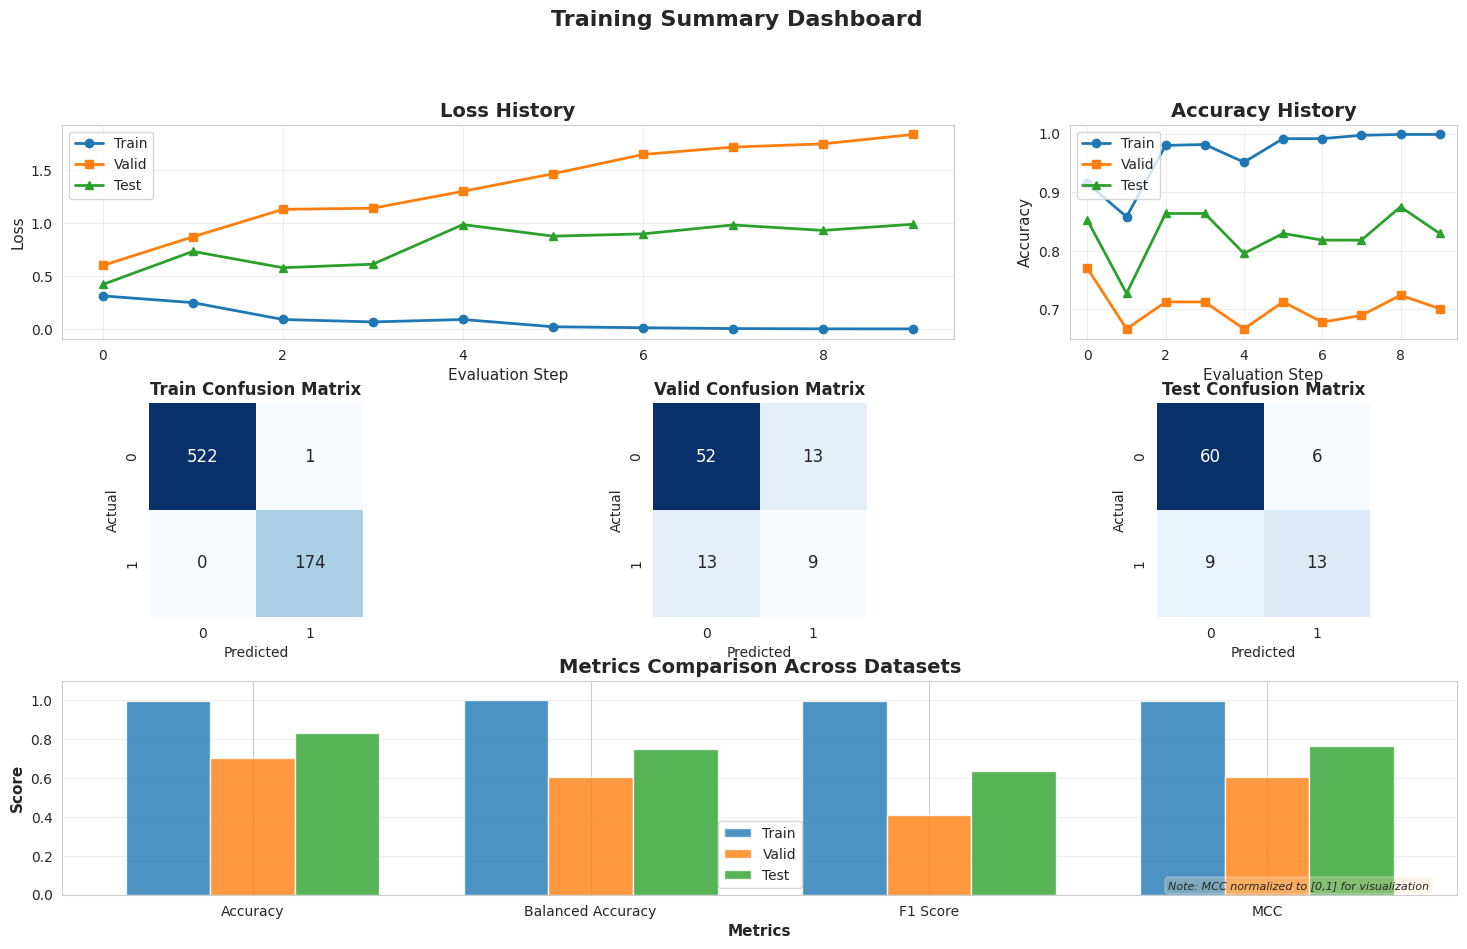


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.8696    0.9091    0.8889        66
     Class 1     0.6842    0.5909    0.6341        22

    accuracy                         0.8295        88
   macro avg     0.7769    0.7500    0.7615        88
weighted avg     0.8232    0.8295    0.8252        88




In [13]:
mf.summarize_training(*results)

### Save Model

In [14]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [15]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_56146/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/22 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (697, 32)
precomputed_embs: (697, 1280)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (697, 32)...
Computing UMAP for precomputed_embs with shape (697, 1280)...

Plotting UMAP embeddings...



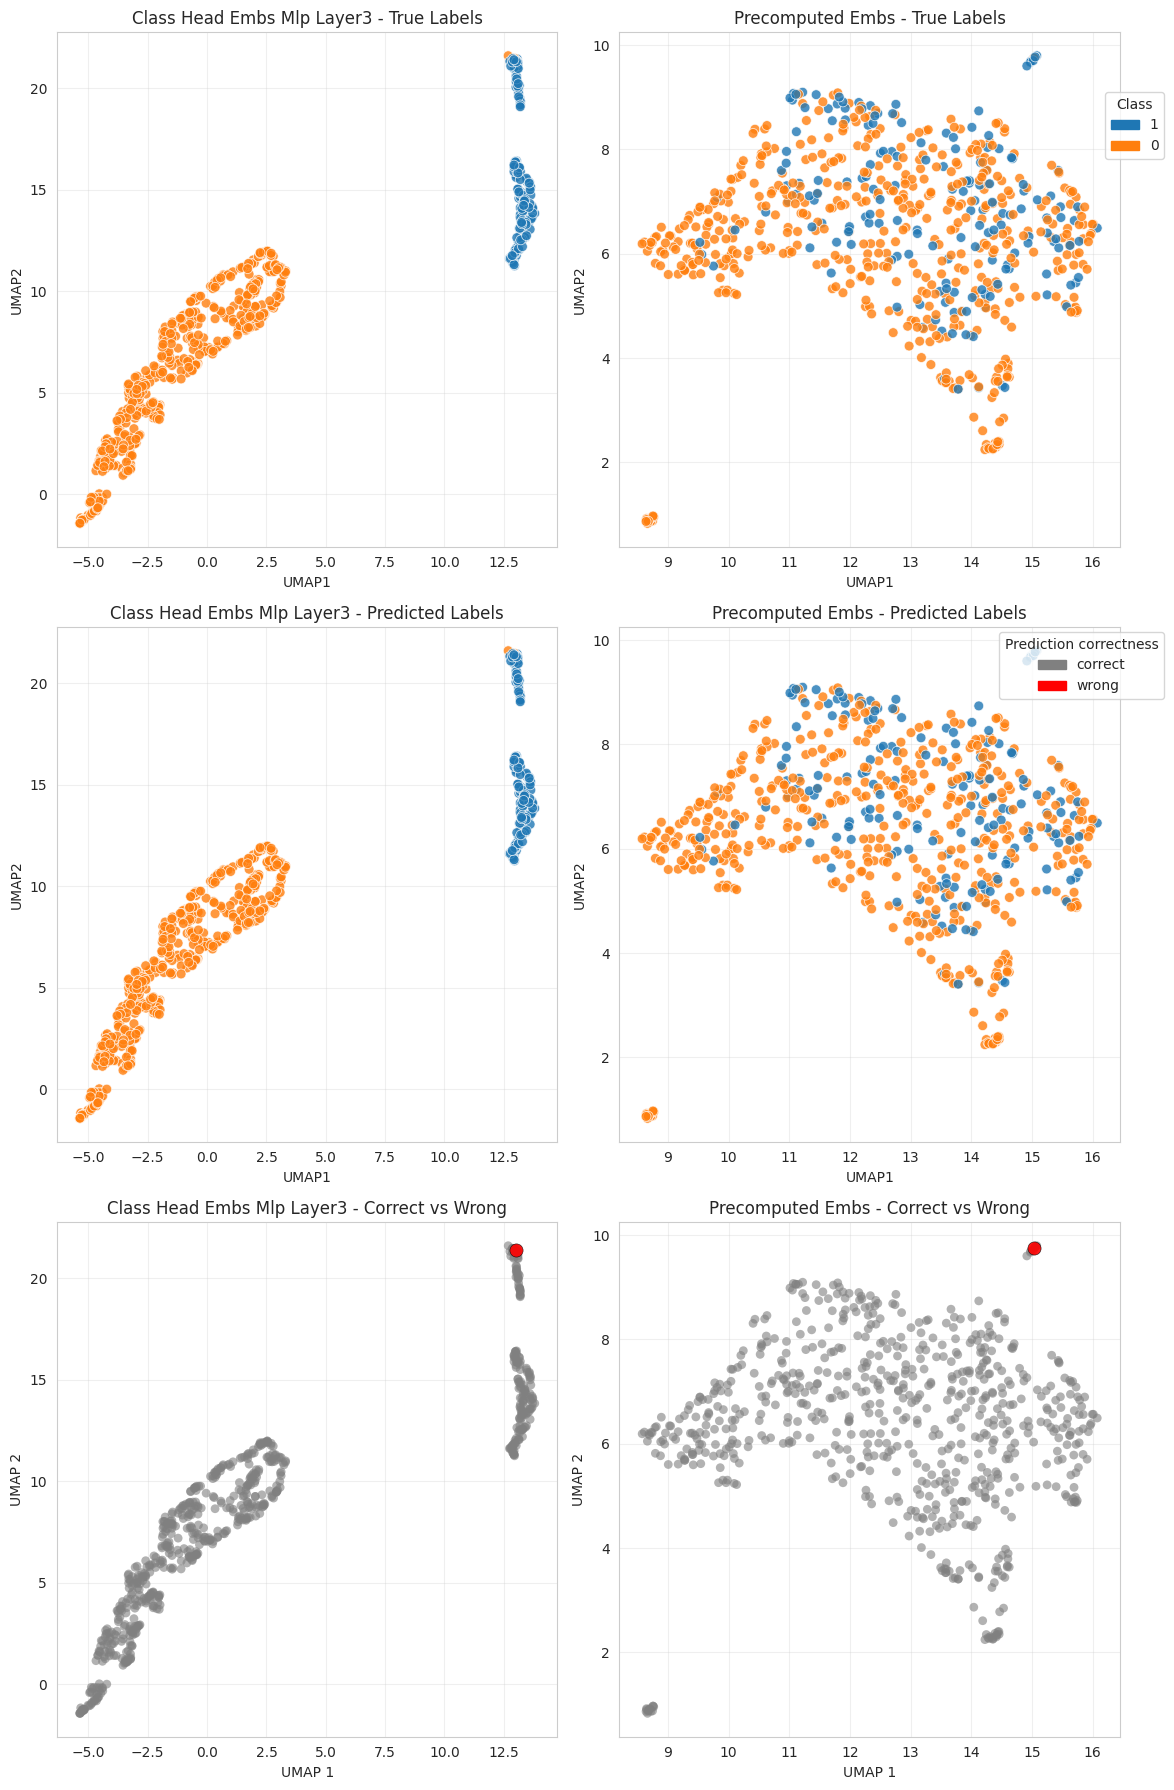

In [16]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")


Extracting embeddings from training set...



Batch:   0%|          | 0/3 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (88, 32)
precomputed_embs: (88, 1280)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (88, 32)...


Computing UMAP for precomputed_embs with shape (88, 1280)...

Plotting UMAP embeddings...



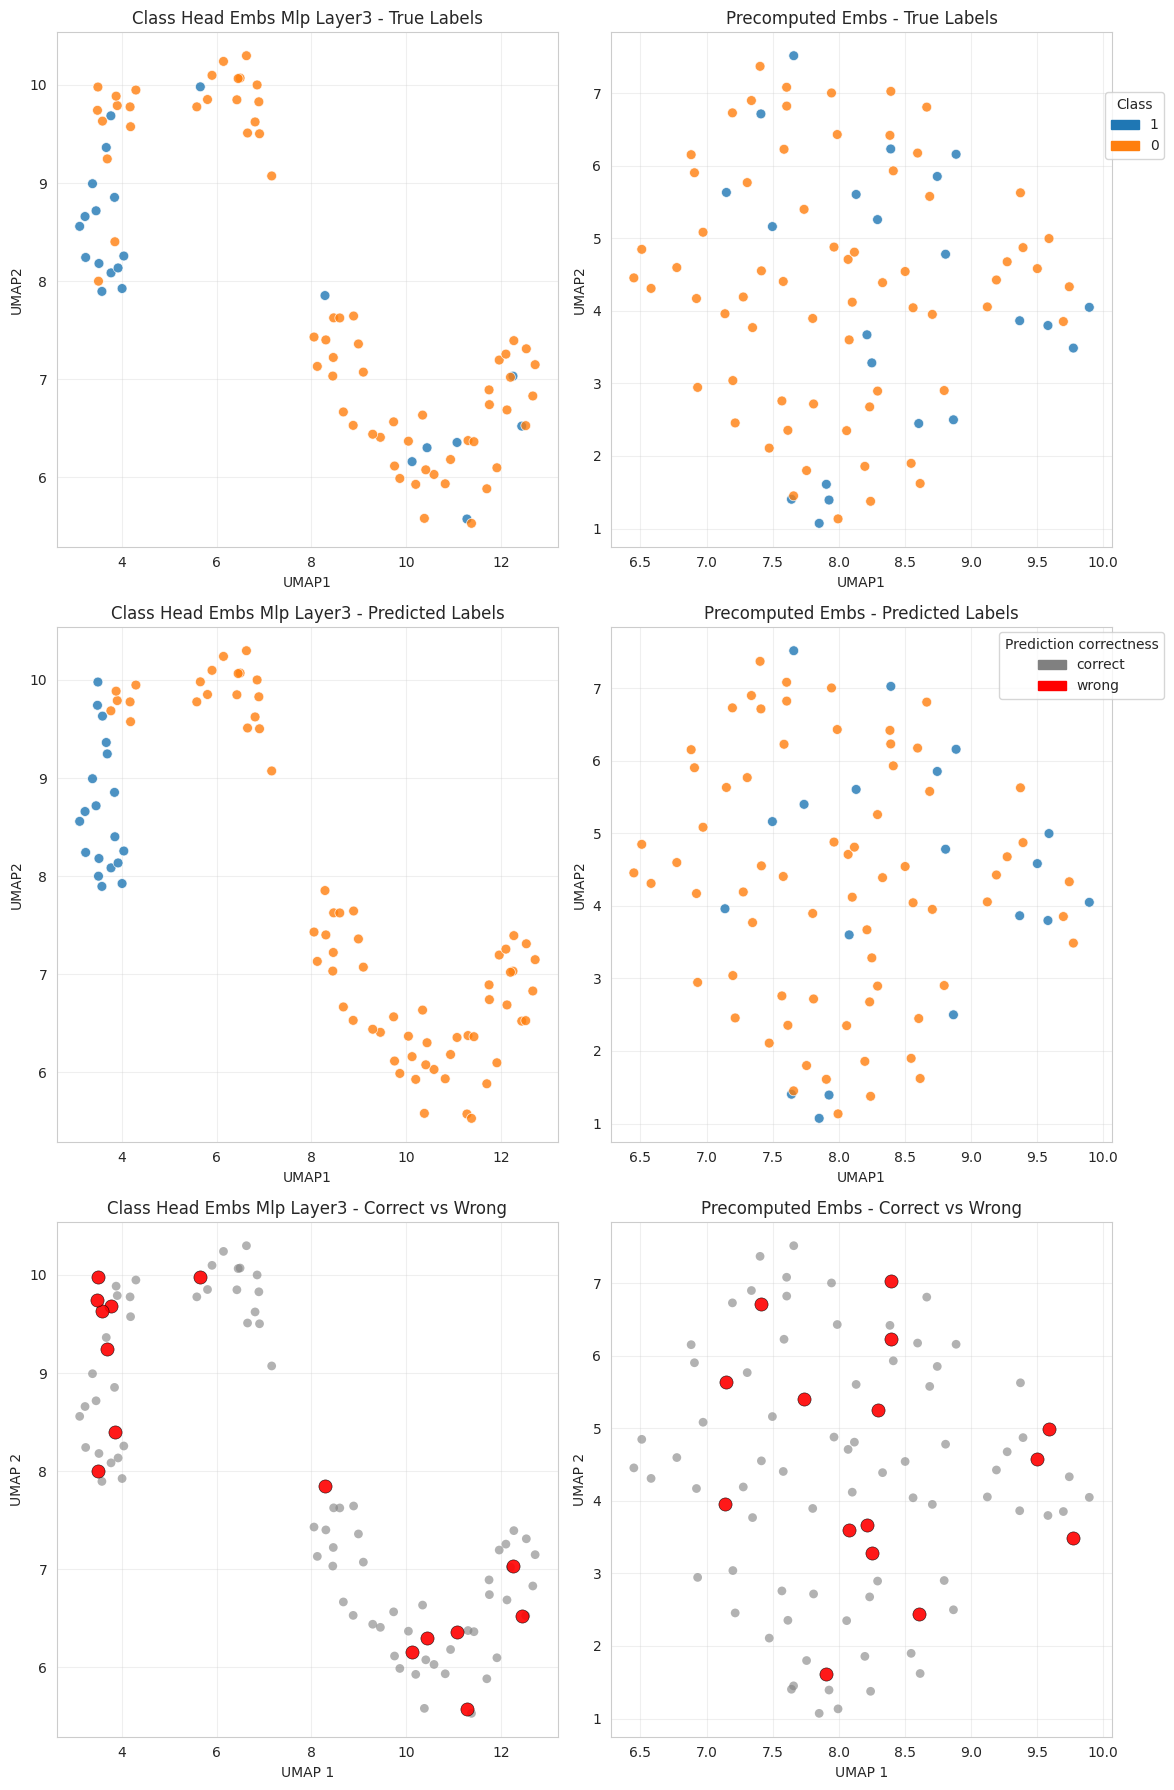

In [17]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")

In [24]:
#df = df["precomputed_embs"]
df[(df["CorrectStr"] != "correct") & (df["TrueClass"] == "1")]

#df[df['CorrectStr'] == 'correct']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
1,Q13207,8.292998,5.259671,1,0,wrong
4,Q8N157,8.392900,6.233549,1,0,wrong
8,Q6ZMS7,7.150087,5.633814,1,0,wrong
9,P04798,8.249969,3.283940,1,0,wrong
10,P30153,9.774202,3.488119,1,0,wrong
11,Q8NFH4,8.604758,2.447873,1,0,wrong
12,Q13616,7.906021,1.609674,1,0,wrong
16,Q71UM5,7.411249,6.716843,1,0,wrong
17,O43542,8.213140,3.671067,1,0,wrong


### A-scanning

In [ ]:
PROTEIN = df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name
#"A0A8V8TKW5" #"P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

scan_results = mf.multi_aa_scanning(net, tokenizer, 
                      single_protein_info, 
                      window_size=WINDOW_SIZE_SUBSTITUION, 
                      substitute_aas=["A", "R", "E", "F"],
                      normalise_true_substitution=False,
                      device=config["DEVICE"])

mf.plot_multi_aa_scan(scan_results, show_per_aa=False)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
